### Evaluation

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:

y_test = y[splits[2]]
learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")     

y_test_preds.shape: (1912, 4, 6)


In [ ]:
#| export

# The forecast error is defined as the difference  between the forecasted value 
# and the actual value. It is also dependant on the time, i.e., on the horizon 
# of the forecast (h).
# NOTE: This function computes the error for just one variable, not for all of them
def forecast_error(y_true, y_pred, h):
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return (y_pred[:, h-1] - y_true[:, h-1])

# forecast error normalized by the actual value
def percent_forecast_error(y_true, y_pred, h):
    # y_true: actual values (samples x steps)
    # y_pred: predicted values (samples x steps)
    # h: horizon of the forecast (1..horizon)
    return 100*(forecast_error(y_true, y_pred, h) / y_true[:, h-1])

In [ ]:
# Test
print(y_test.shape, 
      forecast_error(y_test[:,0,:], y_test_preds[:,0,:], 6).shape,
      percent_forecast_error(y_test[:,0,:], y_test_preds[:,0,:], 6).shape)

(1912, 4, 6) (1912,) (1912,)


The evaluation is done for each variable separately, for each solar activity 
level (low, moderate, elevated and high), as in the paper by Licata et al. (2020)
Therefore, the test set has to be split into 4 different sets, one for each solar activity level. The thresholds for each solar activity level are the same as in the paper by Licata et al. (2020)

The thresholds are:
- F10: 75, 150, 190
- S10: 65, 150, 215
- M10: 72, 144, 167
- Y10: 81, 148, 165

In [ ]:
#|export

def get_idxs_per_solar_activity_level(data, thresholds):
    # function that splits the data of a variable into 4 different sets, 
    # one for each solar activity level. The data comes as a numpy array with 
    # shape (samples, steps), and the split is done along the samples axis. 
    # The decision is made based on the first column of each sample. The function 
    # returns a list of 4 numpy arrays, one for each solar activity level. 
    # But it does not return the values, it returns the indices of the
    # samples that belong to each solar activity level.
    idxs_per_solar_activity_level = []
    for i in range(len(thresholds) + 1):
        if i == 0:
            idxs = np.where(data[:, 0] <= thresholds[i])[0]
        elif i == len(thresholds):
            idxs = np.where(data[:, 0] > thresholds[i-1])[0]
        else:
            idxs = np.where((data[:, 0] > thresholds[i-1]) & (data[:, 0] <= thresholds[i]))[0]
        idxs_per_solar_activity_level.append(idxs)
    return idxs_per_solar_activity_level

In [ ]:
# Call the function for each variable, using y_test
thresholds = {'F10': [75, 150, 190], 
              'S10': [65, 150, 215], 
              'M10': [72, 144, 167], 
              'Y10': [81, 148, 165]}

y_test_split_idxs = {}
for i, var in enumerate(data_columns):
    y_test_split_idxs[var] = get_idxs_per_solar_activity_level(y_test[:, i, :], 
                                                               thresholds[var])
# Check the shape of each variable
for var in data_columns:
    print(f"{var}: {[y_test_split_idxs[var][i].shape for i in range(4)]}")

F10: [(246,), (1436,), (207,), (23,)]
S10: [(139,), (1485,), (288,), (0,)]
M10: [(225,), (1418,), (239,), (30,)]
Y10: [(127,), (1684,), (97,), (4,)]


In [ ]:
# Now split y_test and y_test_preds with the idxs we got, using numpy.take
y_test_split = {}
y_test_preds_split = {}
for var in data_columns:
    y_test_split[var] = [y_test[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]
    y_test_preds_split[var] = [y_test_preds[:, i, :].take(y_test_split_idxs[var][i], axis=0) for i in range(4)]

# Check the shape of each variable in y_test_split
for var in data_columns:
    print(f"y_test-{var}: {[y_test_split[var][i].shape for i in range(4)]}")
    print(f"y_test_preds-{var}: {[y_test_preds_split[var][i].shape for i in range(4)]}")

y_test-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test_preds-F10: [(246, 6), (1436, 6), (207, 6), (23, 6)]
y_test-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test_preds-S10: [(139, 6), (1485, 6), (288, 6), (0, 6)]
y_test-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test_preds-M10: [(225, 6), (1418, 6), (239, 6), (30, 6)]
y_test-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]
y_test_preds-Y10: [(127, 6), (1684, 6), (97, 6), (4, 6)]


In [ ]:
# Create a table (dataframe) with the mean forecast error for each variable (F10, S10, M10, Y10), 
# each solar activity level and each horizon (1..horizon)
data = []
sals = ['low', 'moderate', 'elevated', 'high']
for var_idx, var in enumerate(data_columns):
    for sal_idx,sal in enumerate(sals):
        for h in range(1, config.horizon+1):
            fe_sfu = forecast_error(y_test_split[var][sal_idx], 
                                y_test_preds_split[var][sal_idx], h)
            fe_percent = percent_forecast_error(y_test_split[var][sal_idx],
                                            y_test_preds_split[var][sal_idx], h)
            n_samples = y_test_split[var][sal_idx].shape[0]
            data.append([var, sal, h, np.mean(fe_sfu), np.std(fe_sfu), 
                        np.mean(fe_percent), np.std(fe_percent), n_samples])
df_results = pd.DataFrame(data, columns=['variable', 'condition', 'horizon', 
                                         'µ_sfu', 'σ_sfu', 'µ_percent', 'σ_percent', 'n_samples'])
df_results.head(10)

,variable,condition,horizon,µ_sfu,σ_sfu,µ_percent,σ_percent,n_samples
0,F10,low,1,0.443836,1.391069,0.622663,1.915725,246
1,F10,low,2,0.484913,1.954837,0.701264,2.664570,246
2,F10,low,3,0.573539,2.657455,0.855494,3.571209,246
3,F10,low,4,0.648495,3.445885,1.008432,4.565976,246
4,F10,low,5,0.586338,4.217087,0.998412,5.463134,246
5,F10,low,6,0.482710,4.985801,0.941863,6.284475,246
6,F10,moderate,1,0.108971,2.788079,0.145801,2.361018,1436
7,F10,moderate,2,0.146513,4.330943,0.245040,3.636675,1436
8,F10,moderate,3,0.150961,5.730390,0.339202,4.784774,1436
9,F10,moderate,4,0.140450,7.037706,0.440897,5.844342,1436


In [ ]:
# Divide the table into one dataframe for each variable, and print it in a way
# that has the same format as the table in the paper, that is:
# Columns: | Condition | Statistics | 1 Day | 2 Days | 3 Days | ... | {{horizon}} Days,
# where condition is the variable and the solar activity level, and statistics 
# is the mean (column mean_fe) and the standard deviation (std_fe) of the forecast error.
for var in data_columns:
    df_var = df_results[df_results['variable'] == var].drop(columns=['variable', 
                                                                     'µ_percent', 
                                                                     'σ_percent'])
    df_var = df_var.melt(id_vars=['condition', 'horizon'], 
                         value_vars=['µ_sfu', 'σ_sfu'], 
                         var_name='Statistic')
    # Sort the values of the column condition so that the order is 
    # low, moderate, elevated, high
    df_var['condition'] = pd.Categorical(df_var['condition'], 
                                      categories=['low', 'moderate', 'elevated', 'high'], 
                                      ordered=True)
    df_var = df_var.pivot_table(index=['condition', 'Statistic'], 
                          columns='horizon', 
                          values='value')
    # pretty print, and separate with a blank line
    print(df_var.to_string(), '\n')


horizon                     1         2         3          4          5          6
condition Statistic                                                               
low       µ_sfu      0.443836  0.484913  0.573539   0.648495   0.586338   0.482710
          σ_sfu      1.391069  1.954837  2.657455   3.445885   4.217087   4.985801
moderate  µ_sfu      0.108971  0.146513  0.150961   0.140450   0.064943  -0.009214
          σ_sfu      2.788079  4.330943  5.730390   7.037706   8.238856   9.206183
elevated  µ_sfu     -2.165002 -3.024804 -3.464280  -3.622353  -3.335035  -2.863251
          σ_sfu      3.689585  5.922861  8.448487  10.238268  11.809207  12.760235
high      µ_sfu     -2.312724 -3.033466 -4.281806  -4.872100  -4.070702  -2.290207
          σ_sfu      3.768242  4.860982  5.370842   6.688216   8.347853   9.536629 

horizon                     1         2         3          4          5          6
condition Statistic                                                               
lo

### Visualize predictions

In [ ]:
dtms = prepare_forecasting_data(df.reset_index(), fcst_history=config.lookback, 
                                fcst_horizon=config.horizon, x_vars='Date', y_vars='Date')
dtms = np.concatenate((dtms[0], dtms[1]), axis=2).squeeze(axis=1)
dtms.shape

(9485, 42)

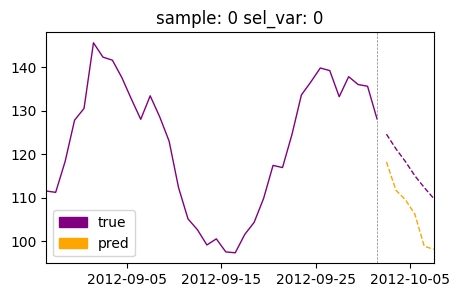

In [ ]:
# hide
X_test = X[splits[2]]
y_test = y[splits[2]]
dtms_test = dtms[splits[2]]
plot_forecast_2(X_test, y_test, y_test_preds, dtms=dtms_test, sel_vars=0, idx=0, 
                figsize=(5,3), n_samples=1)

In [ ]:
def plot_solar_algorithm_performance(df, var, figsize=(10, 10), ylims_mean=None, ylims_std=None):
    # Plot a grid where each row is a solar activity level, and each column
    # is a error type (sfu or percent). Each cell is the result of calling the 
    # function plot_fe.
    # Input:
    # df: dataframe with the results of the forecasting experiment, with the columns
    #     variable, condition, horizon, µ_sfu, σ_sfu, µ_percent, σ_percent
    # var: variable to plot (F10, S10, M10, Y10)
    # figsize: figure size
    # ylims_mean: List with the y limits of the mean for each error type: 
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # ylims_std: List with the y limits of the standard deviation for each error type:
    #   [(percent[0], percent[1]), (sfu[0], sfu[1])]
    # Output:
    # None, but it plots the grid
    sals = ['low', 'moderate', 'elevated', 'high']
    fig, axs = plt.subplots(len(sals), 2, figsize=figsize)
    fig.suptitle(f"Forecast error for {var}")
    for sal_idx, sal in enumerate(sals):
        for idx, err_type in enumerate(['percent', 'sfu']):
            df_var = df[(df['variable'] == var) & (df['condition'] == sal)]
            # Minimum and maximum values across column
            min_val_mean = df[f'µ_{err_type}'].min() if ylims_mean is None else ylims_mean[idx][0]
            max_val_mean = df[f'µ_{err_type}'].max() if ylims_mean is None else ylims_mean[idx][1]
            min_val_std = df[f'σ_{err_type}'].min() if ylims_std is None else ylims_std[idx][0]
            max_val_std = df[f'σ_{err_type}'].max() if ylims_std is None else ylims_std[idx][1]

            mean_fe = df_var[f'µ_{err_type}'].values
            std_fe = df_var[f'σ_{err_type}'].values
            ax = axs[sal_idx, idx]
            ax.plot(mean_fe, color='#000000')
            ax.set_xlabel('Days from Epoch')
            ax.set_ylabel(f'Mean [{err_type}]', color='#000000')
            ax.tick_params(axis='y', labelcolor='#000000')
            ax.set_xticks(range(len(mean_fe)))
            ax.set_xticklabels(range(1, len(mean_fe)+1))
            ax.set_ylim(min_val_mean, max_val_mean)
            ax2 = ax.twinx()
            ax2.plot(std_fe, color='tab:red')
            ax2.set_ylabel(f'STD [{err_type}]', color='tab:red')
            ax2.set_ylim(min_val_std, max_val_std)
            ax2.tick_params(axis='y', labelcolor='tab:red')
            # ax2.set_xticks(range(len(std_fe)))
            # ax2.set_xticklabels(range(1, len(std_fe)+1))
            n_samples = df_var['n_samples'].values[0] 
            ax.set_title(f'{sal}\n{n_samples} forecasts')
            # Draw a grid in the background
            ax.grid(True, which='both', axis='both', color='lightgrey',
                    linestyle='-', linewidth=0.5)
            fig.tight_layout()

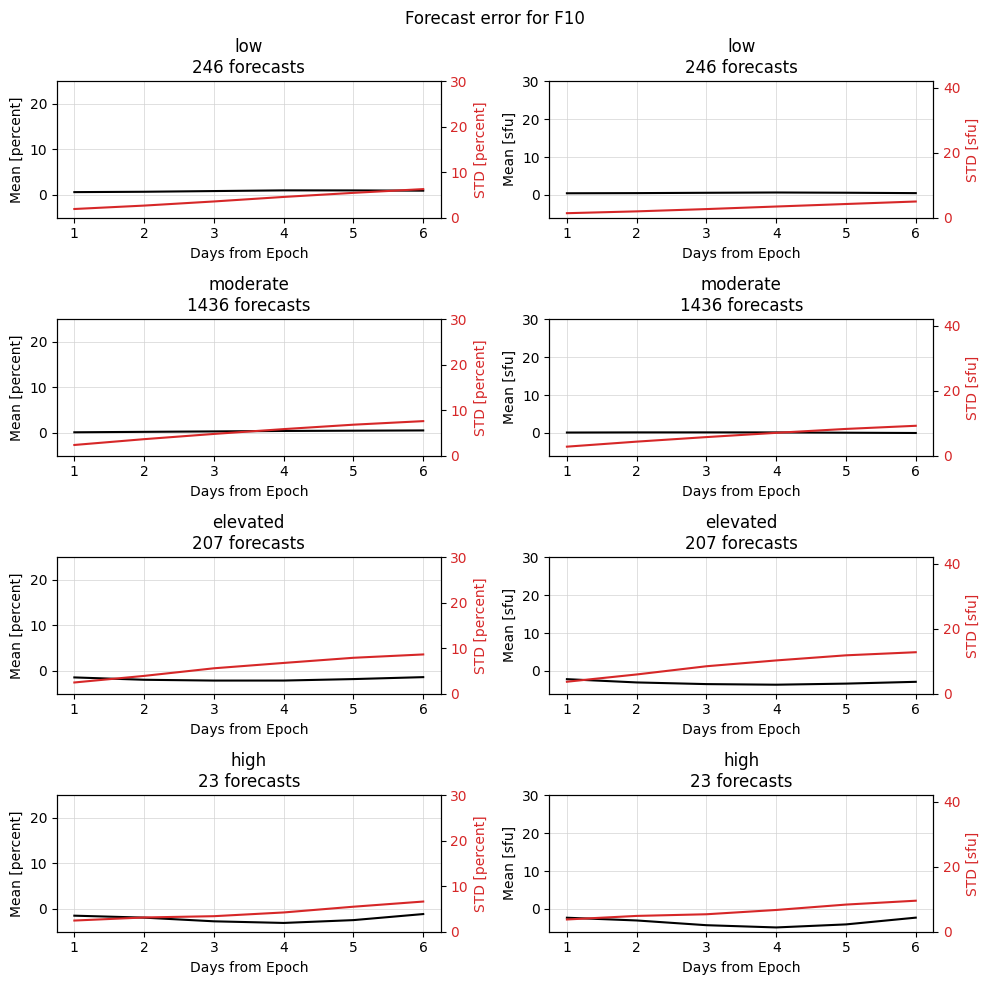

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'F10', ylims_mean=[(-5, 25), (-6, 30)],
                                 ylims_std=[(0, 30), (0, 42)])

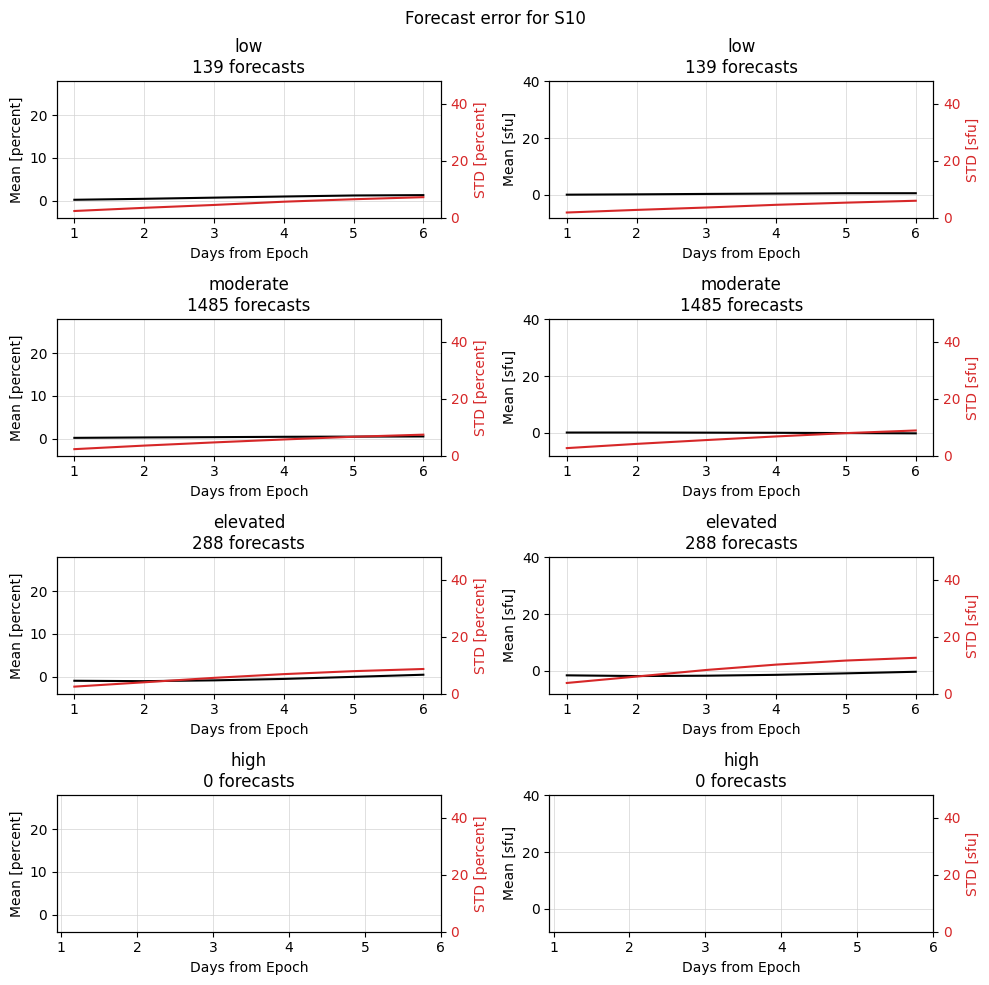

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'S10', ylims_mean=[(-4, 28), (-8, 40)],
                                 ylims_std=[(0, 48), (0, 48)])

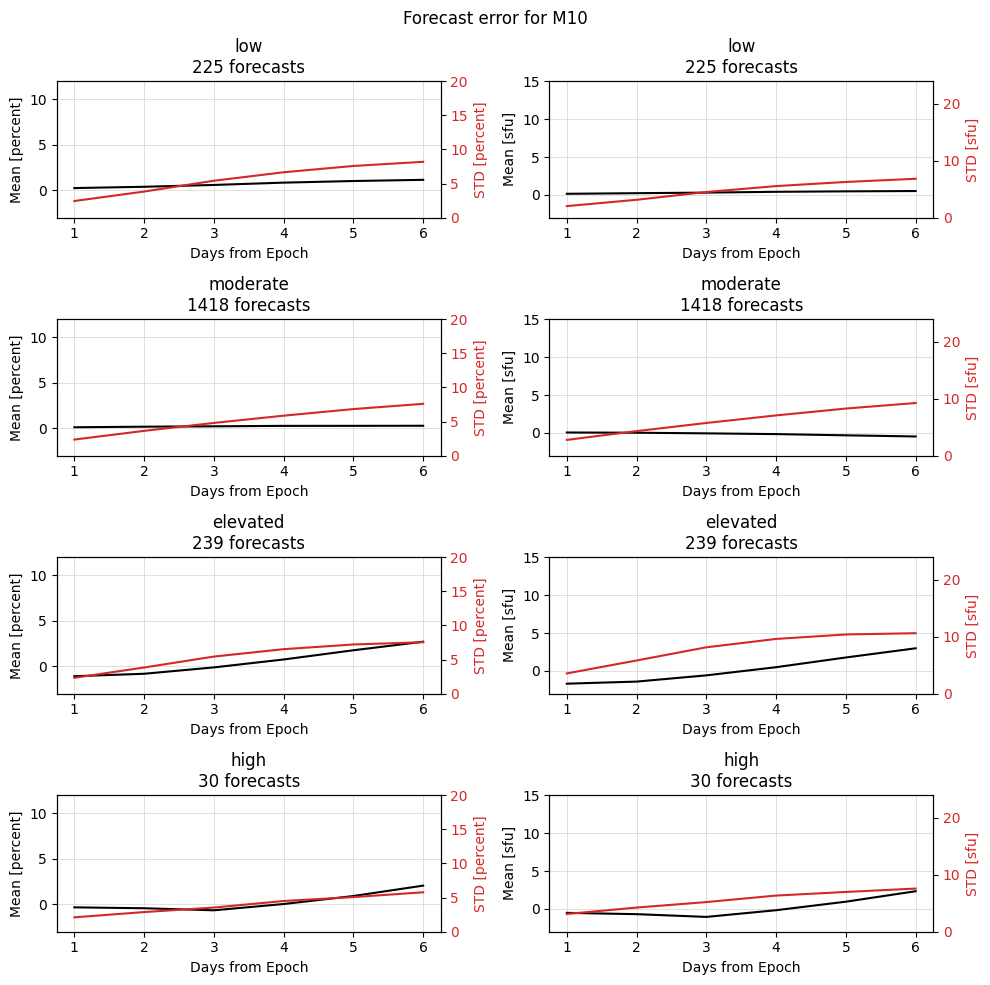

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'M10', ylims_mean=[(-3, 12), (-3, 15)],
                                 ylims_std=[(0, 20), (0, 24)])

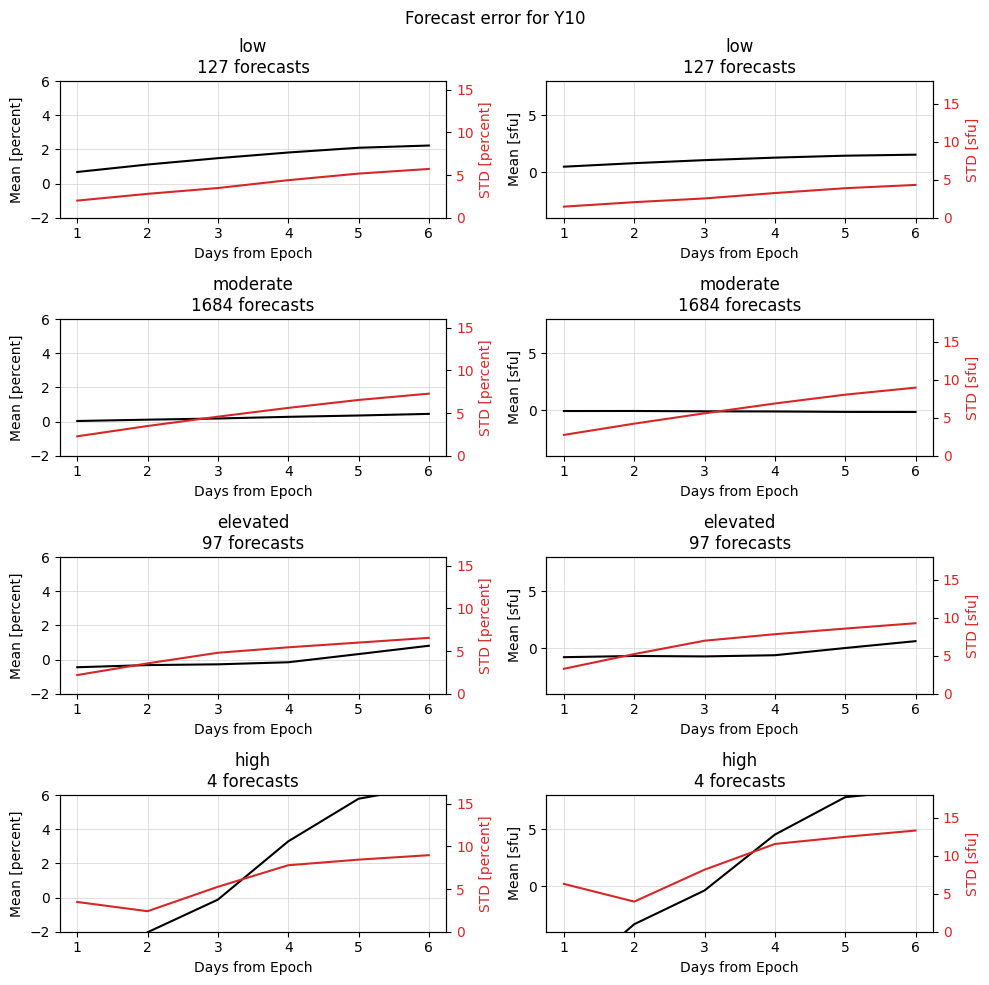

In [ ]:
# hide
plot_solar_algorithm_performance(df_results, 'Y10', ylims_mean=[(-2, 6), (-4, 8)],
                                 ylims_std=[(0, 16), (0, 18)])